### Predicting Movie Licensing

In this project we would analyse a data set of movies and their attributes such as their genre, language, number of writers and more. With the ultimate aim of identifying attibutes that may effect potential earnings, and build a predictive model to aid in the decision to license certain movie titles or not. 

To acheive this we are going go through the following steps iteratively:

1. Cleaning
2. Exploratory Data Analysis
3. Preprocessing
4. Feature Engineering
5. Modelling
6. Valuation

### Cleaning and Exploration
Before we model we should first view the data set for inconsistencies and missing values. After observing the rows displayed below, we see that some rows have inconsistent data types and missing values.

We will follow the following process:

1. Read in data
2. Assess data
2. Handle inconsistent data types starting using Class label as a benchmark.
3. Transform Data Types
4. Handle missing values accordingly.
7. Find and remove duplicates.
8. Search and treat outliers.

In [1]:
#import modules

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder, PolynomialFeatures, StandardScaler
from sklearn.impute import KNNImputer
from sklearn.metrics import log_loss, f1_score
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from sklearn.model_selection import train_test_split, cross_val_score, RepeatedStratifiedKFold, RandomizedSearchCV
from imblearn.pipeline import Pipeline


In [2]:
import warnings
warnings.filterwarnings("ignore")

In [3]:
train =  pd.read_csv("../input/switch/train.csv")
test = pd.read_csv("../input/switch/test.csv")

#### Assess Data

In [4]:
train.head()

,title,country,genres,language,writer_count,title_adaption,censor_rating,release_date,runtime,dvd_release_date,...,likes,overall_views,dislikes,ratings_imdb,ratings_tomatoes,ratings_metacritic,special_award,awards_win,awards_nomination,revenue_category
0,Pooh's Heffalump Movie,USA,"Animation, Comedy, Family, Fantasy, Musical, M...",English,3.0,True,G,11-Feb-05,68 min,24-May-05,...,NaN,NaN,NaN,6.4/10,80%,64/100,0,0,1,High
1,Yeh Jawaani Hai Deewani,India,"Comedy, Drama, Musical, Romance","Hindi, English, French",2.0,True,Not Rated,31-May-13,160 min,15-Jul-13,...,124.0,127528.0,12.0,7.1/10,67%,0,0,22,92,Low
2,Tae Guk Gi: The Brotherhood of War,South Korea,"Action, Drama, War",Korean,4.0,False,R,24-Sep-04,140 min,15-Feb-05,...,614.0,351123.0,18.0,8.1/10,80%,64/100,0,12,7,Low
3,"Book of Eli, The",USA,"Action, Adventure, Drama, Thriller",English,1.0,False,R,15-Jan-10,118 min,15-Jun-10,...,NaN,NaN,NaN,6.9/10,47%,53/100,0,3,16,High
4,Blind Dating,USA,"Comedy, Romance",English,1.0,False,PG-13,26-Apr-07,95 min,05-Feb-08,...,693.0,970306.0,36.0,6.1/10,25%,0,0,0,0,Low


In [5]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2400 entries, 0 to 2399
Data columns (total 22 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   title               2398 non-null   object 
 1   country             2400 non-null   object 
 2   genres              2400 non-null   object 
 3   language            2400 non-null   object 
 4   writer_count        2306 non-null   float64
 5   title_adaption      2400 non-null   bool   
 6   censor_rating       2362 non-null   object 
 7   release_date        2396 non-null   object 
 8   runtime             2400 non-null   object 
 9   dvd_release_date    2331 non-null   object 
 10  users_votes         2400 non-null   object 
 11  comments            1974 non-null   float64
 12  likes               1956 non-null   float64
 13  overall_views       2083 non-null   float64
 14  dislikes            1956 non-null   float64
 15  ratings_imdb        2400 non-null   object 
 16  rating

*Note*: There are 2400 entries in the data set with, 21 columns. A handfull of columns have missing values. Most problematic would be the movie titles.

#### Investigate and Handle Missingness
Here, we will take a deep look at missing values to understand the nature of missingness and deal with them accordingly. 

We would create a function to print out data with values missing in column

In [6]:
def print_missing(column):
    "Prints out rows with missing values for specified column as string"
    return train[train[column].isna()]

In [7]:
#print number of missing values per column
train.isna().sum()

title                   2
country                 0
genres                  0
language                0
writer_count           94
title_adaption          0
censor_rating          38
release_date            4
runtime                 0
dvd_release_date       69
users_votes             0
comments              426
likes                 444
overall_views         317
dislikes              444
ratings_imdb            0
ratings_tomatoes        0
ratings_metacritic      0
special_award           0
awards_win              0
awards_nomination       0
revenue_category        0
dtype: int64

In [8]:
# print list of columns with missing values
train.columns[train.isna().sum() > 0]

Index(['title', 'writer_count', 'censor_rating', 'release_date',
       'dvd_release_date', 'comments', 'likes', 'overall_views', 'dislikes'],
      dtype='object')

In [9]:
#investigate missing titles
print_missing("title")

,title,country,genres,language,writer_count,title_adaption,censor_rating,release_date,runtime,dvd_release_date,...,likes,overall_views,dislikes,ratings_imdb,ratings_tomatoes,ratings_metacritic,special_award,awards_win,awards_nomination,revenue_category
9,NaN,USA,"Comedy, Drama, Romance","English, French, Swedish",2.0,False,PG-13,07-Aug-09,95 min,22-Dec-09,...,1646.0,561553.0,47.0,7.7/10,85%,76/100,1,17,54,High
2001,NaN,USA,"Comedy, Drama, Music",English,2.0,False,R,02-Jun-11,96 min,01-Jun-10,...,103.0,66081.0,11.0,6.4/10,65%,58/100,0,2,0,Low


***Note***: Two names in the title column are missing. We can leave these however, as the title would likely not have predictive power, and will not be used as model input.

In [10]:
#print missing writer counts
print_missing('writer_count').head()

,title,country,genres,language,writer_count,title_adaption,censor_rating,release_date,runtime,dvd_release_date,...,likes,overall_views,dislikes,ratings_imdb,ratings_tomatoes,ratings_metacritic,special_award,awards_win,awards_nomination,revenue_category
20,Sweetgrass,"France, UK, USA","Documentary, Adventure, Western",English,NaN,False,Unrated,22-Apr-11,101 min,03-Aug-10,...,265.0,140425.0,9.0,6.9/10,97%,80/100,0,1,10,Low
57,Genius Within: The Inner Life of Glenn Gould,Canada,"Documentary, Biography, Music",English,NaN,False,Not Rated,10-Sep-10,106 min,01-Mar-11,...,146.0,62950.0,1.0,7.4/10,84%,72/100,0,1,4,Low
62,First Descent,USA,"Documentary, Sport",English,NaN,False,PG-13,02-Dec-05,110 min,21-Feb-06,...,NaN,NaN,NaN,7.2/10,52%,51/100,0,0,0,Low
67,Dear Mr. Watterson,USA,Documentary,English,NaN,False,PG,18-May-14,89 min,21-Apr-14,...,1035.0,146890.0,14.0,6.4/10,62%,54/100,0,0,0,Low
81,Boxing Gym,USA,Documentary,English,NaN,False,UNRATED,09-Mar-11,91 min,28-Jul-14,...,98.0,48521.0,9.0,7.1/10,95%,83/100,0,0,3,Low


In [11]:
train.writer_count = train.writer_count.fillna(0).astype(int)

***Note: I observe that writer counts are only missing in title columns where title_adaptation is false and they are documentaries. We can replace NAs here with zero.***

In [12]:
#print missing censor ratings
print_missing('censor_rating').head()

,title,country,genres,language,writer_count,title_adaption,censor_rating,release_date,runtime,dvd_release_date,...,likes,overall_views,dislikes,ratings_imdb,ratings_tomatoes,ratings_metacritic,special_award,awards_win,awards_nomination,revenue_category
111,"Mother's Courage: Talking Back to Autism, A",Iceland,Documentary,"English, Icelandic",0,False,NaN,02-Apr-10,103 min,26-Oct-10,...,119.0,45077.0,5.0,7.5/10,56%,76/100,0,0,2,Low
138,"I Love You, I Love You",France,"Drama, Sci-Fi","French, Dutch, English",1,False,NaN,24-Apr-68,91 min,NaN,...,190.0,77787.0,6.0,7.3/10,86%,0,0,2,0,Low
166,"Intruder, The",France,Drama,"French, English, Korean, Russian, Polynesian",3,True,NaN,04-May-05,130 min,25-Apr-06,...,NaN,NaN,NaN,7.0/10,86%,85/100,0,0,4,Low
220,Mugabe and the White African,UK,Documentary,"English, Shona",0,False,NaN,07-Aug-09,90 min,14-Dec-10,...,213.0,83387.0,18.0,7.8/10,97%,77/100,1,2,6,Low
355,"Kings of Mykonos, The","Australia, Greece",Comedy,"English, Greek",2,False,NaN,20-May-10,102 min,NaN,...,314.0,341608.0,23.0,4.6/10,30%,0,0,0,1,Low


***Note Censor Rating does not seem to be missing at random***

In [13]:
print_missing('release_date')

,title,country,genres,language,writer_count,title_adaption,censor_rating,release_date,runtime,dvd_release_date,...,likes,overall_views,dislikes,ratings_imdb,ratings_tomatoes,ratings_metacritic,special_award,awards_win,awards_nomination,revenue_category
215,Bringing Up Bobby,"USA, Netherlands, UK",Comedy,English,3,True,PG-13,NaN,93 min,19-Nov-12,...,193.0,178736.0,19.0,5.2/10,17%,34/100,0,0,0,Low
1427,Dirty Money,"France, Italy","Crime, Thriller",French,1,False,PG,NaN,98 min,22-Mar-05,...,NaN,8288.0,NaN,7.1/10,78%,72/100,0,0,0,Low
2002,Passion Play,USA,"Drama, Fantasy, Romance",English,1,True,R,NaN,94 min,31-May-11,...,881.0,880049.0,278.0,4.8/10,3%,22/100,0,0,0,Low
2201,Close,Germany,Drama,German,2,False,NaN,NaN,84 min,29-Mar-05,...,4.0,5556.0,0.0,6.6/10,68%,0,0,0,0,High


*Note: 4 values for release date are missing in the dataset, they seem to be missing randomly, we can treat them by googling their release dates*

In [14]:
## Adding release date
train.at[215, "release_date"] = pd.to_datetime('2012-09-28')
train.at[2002, "release_date"] = pd.to_datetime('2011-05-06')

In [15]:
print_missing('dvd_release_date').head()

,title,country,genres,language,writer_count,title_adaption,censor_rating,release_date,runtime,dvd_release_date,...,likes,overall_views,dislikes,ratings_imdb,ratings_tomatoes,ratings_metacritic,special_award,awards_win,awards_nomination,revenue_category
15,Somm,USA,Documentary,"English, Italian, German, French",1,False,Not Rated,21-Jun-13,94 min,NaN,...,9.0,2478.0,0.0,7.0/10,79%,58/100,0,1,2,Low
46,On My Way,France,"Comedy, Drama",French,2,True,Not Rated,18-Sep-13,116 min,NaN,...,7.0,3574.0,0.0,6.4/10,80%,60/100,0,1,5,Low
68,Just a Sigh,"France, Belgium, Ireland","Drama, Romance","French, English",1,False,NOT RATED,10-Jun-14,104 min,NaN,...,20.0,14588.0,0.0,6.5/10,44%,58/100,0,5,1,Low
77,Housefull 2,India,"Action, Comedy, Musical, Romance",Hindi,7,True,Not Rated,05-Apr-12,145 min,NaN,...,NaN,NaN,NaN,5.4/10,17%,0,0,9,7,Low
138,"I Love You, I Love You",France,"Drama, Sci-Fi","French, Dutch, English",1,False,NaN,24-Apr-68,91 min,NaN,...,190.0,77787.0,6.0,7.3/10,86%,0,0,2,0,Low


***Note***: There is no obvious pattern to why some dvd_release_dates are missing. They seem to be missing at random. A theory is that tese movies where never released on DVD.


In [16]:
print_missing("comments").head()

,title,country,genres,language,writer_count,title_adaption,censor_rating,release_date,runtime,dvd_release_date,...,likes,overall_views,dislikes,ratings_imdb,ratings_tomatoes,ratings_metacritic,special_award,awards_win,awards_nomination,revenue_category
0,Pooh's Heffalump Movie,USA,"Animation, Comedy, Family, Fantasy, Musical, M...",English,3,True,G,11-Feb-05,68 min,24-May-05,...,NaN,NaN,NaN,6.4/10,80%,64/100,0,0,1,High
3,"Book of Eli, The",USA,"Action, Adventure, Drama, Thriller",English,1,False,R,15-Jan-10,118 min,15-Jun-10,...,NaN,NaN,NaN,6.9/10,47%,53/100,0,3,16,High
6,Jet Lag,"France, UK","Comedy, Romance",French,2,False,R,30-Oct-02,91 min,20-Jan-04,...,NaN,NaN,NaN,6.2/10,57%,53/100,0,0,1,Low
11,Romeo and Juliet,"UK, Italy, Switzerland","Drama, Romance","English, Latin",3,True,PG-13,11-Oct-13,113 min,04-Feb-14,...,NaN,NaN,NaN,5.8/10,24%,41/100,0,2,2,Low
12,Winnebago Man,USA,"Documentary, Biography, Comedy",English,6,False,Not Rated,14-Mar-09,85 min,02-Nov-10,...,NaN,NaN,NaN,7.2/10,90%,71/100,0,5,0,Low


In [17]:
print_missing('likes').head()

,title,country,genres,language,writer_count,title_adaption,censor_rating,release_date,runtime,dvd_release_date,...,likes,overall_views,dislikes,ratings_imdb,ratings_tomatoes,ratings_metacritic,special_award,awards_win,awards_nomination,revenue_category
0,Pooh's Heffalump Movie,USA,"Animation, Comedy, Family, Fantasy, Musical, M...",English,3,True,G,11-Feb-05,68 min,24-May-05,...,NaN,NaN,NaN,6.4/10,80%,64/100,0,0,1,High
3,"Book of Eli, The",USA,"Action, Adventure, Drama, Thriller",English,1,False,R,15-Jan-10,118 min,15-Jun-10,...,NaN,NaN,NaN,6.9/10,47%,53/100,0,3,16,High
6,Jet Lag,"France, UK","Comedy, Romance",French,2,False,R,30-Oct-02,91 min,20-Jan-04,...,NaN,NaN,NaN,6.2/10,57%,53/100,0,0,1,Low
11,Romeo and Juliet,"UK, Italy, Switzerland","Drama, Romance","English, Latin",3,True,PG-13,11-Oct-13,113 min,04-Feb-14,...,NaN,NaN,NaN,5.8/10,24%,41/100,0,2,2,Low
12,Winnebago Man,USA,"Documentary, Biography, Comedy",English,6,False,Not Rated,14-Mar-09,85 min,02-Nov-10,...,NaN,NaN,NaN,7.2/10,90%,71/100,0,5,0,Low


***Note: most values where comments are missing likes, dislikes, overall views are missing as well.***

#### Using Appropriate Data Types

1. Transform Runtime column to numeric, by removing the Minute(`min`) suffix.
2. Take out the percentage sign from `ratings_tomatoes` column
3. Remove denominators from ÌMDB and Metacritic ratings to make them into numerical figures.
4. Converting release_date and dvd_release_date.

In [18]:
def correct_datatypes(data):
    "given data it converts data types of certain columns"

    #remove minute unit from runtime
    data.runtime = data.runtime.str[:-4].astype(int)

    #remove percentage sign from rating_tomato 
    data.ratings_tomatoes = data.ratings_tomatoes.str.replace("%", "").astype(int)

    #remove denominator from rating_imdb
    data.ratings_imdb = data.ratings_imdb.str.replace('/10', '').astype(float)

    #remove denominator from rating_metacritic
    data.ratings_metacritic = data.ratings_metacritic.str.replace('/100', '').astype(int)

    #remove convert release date to datetime
    data.release_date = pd.to_datetime(data.release_date)

    #remove convert release date to datetime
    data.dvd_release_date = pd.to_datetime(data.dvd_release_date)

    data.users_votes = data.users_votes.str.replace(",", '').astype(int)
    
    return data

In [19]:
#apply correct data type to train and test set
train = correct_datatypes(train)
test = correct_datatypes(test)

In [20]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2400 entries, 0 to 2399
Data columns (total 22 columns):
 #   Column              Non-Null Count  Dtype         
---  ------              --------------  -----         
 0   title               2398 non-null   object        
 1   country             2400 non-null   object        
 2   genres              2400 non-null   object        
 3   language            2400 non-null   object        
 4   writer_count        2400 non-null   int64         
 5   title_adaption      2400 non-null   bool          
 6   censor_rating       2362 non-null   object        
 7   release_date        2398 non-null   datetime64[ns]
 8   runtime             2400 non-null   int64         
 9   dvd_release_date    2331 non-null   datetime64[ns]
 10  users_votes         2400 non-null   int64         
 11  comments            1974 non-null   float64       
 12  likes               1956 non-null   float64       
 13  overall_views       2083 non-null   float64     

#### Cleaning the Rating column
Censor column contains both Not rated and Unrated which carry the same information, they are also often in different capitalizations. 

In [21]:
#make capitalization uniform and recode UNRATED as 'Not Rated'
train.censor_rating = train.censor_rating.str.upper()
train.censor_rating = train.censor_rating.replace('UNRATED', 'NOT RATED')

test.censor_rating = test.censor_rating.str.upper()
test.censor_rating = test.censor_rating.replace('UNRATED', 'NOT RATED')

#### Cleaning the genre, country and language column

The genre, country and languages column have multipl entries per row. Here we create a unique column for each genre, country and language, these columns will be binary columns with `1` if that column contains a particular entry and `0` otherwise.

In [22]:
#create a set of all genres
genres = set()
for genre in train.genres.str.split(',').values:
    genres = genres.union(set(genre))

### Genres contain a set of genres in the dataset, however some instances have whitespace hence are duplicated.   

genre_list = []
for g in genres:
    genre_list.append(g.strip()) #remove whitespace
    
genre_set = set(genre_list)


#create a set of all countries
countries = set()
for country in train.country.str.split(',').values:
     countries = countries.union(set(country))
   
### Countries contain a set of countries in the dataset, however some instances have whitespace hence are duplicated.
country_list = []
for c in countries:
    country_list.append(c.strip()) #remove whitespace
    
country_set = set(country_list)

#create a set of all language
languages = set()
for language in train.language.str.split(',').values:
     languages = languages.union(set(language))
   
###Languages contain a set of countries in the dataset, however some instances have whitespace hence are duplicated.
language_list = []
for l in languages:
    language_list.append(l.strip()) #remove whitespace
    
language_set = set(language_list)

In [23]:
def create_new_columns(genre_set, country_set, language_set, data):
    "Create new columns"
    #create dict to store how many times each genre appears
    genre_count = {}
    for genre in genre_set:
        x = np.where(data.genres.str.contains(genre), 1, 0)
        data[genre] = x #create boolean column for each genre
        genre_count[genre] = sum(x)

    # dictionary to count each time a country appears
    country_count = {}
    for country in country_set:
        x = np.where(data.country.str.contains(country), 1, 0)
        data[country] = x #creates boolean column for each country
        country_count[country] = sum(x)

    # dictionary to count each time a language appears
    language_count = {}
    for language in language_set:
        x = np.where(data.language.str.contains(language), 1, 0)
        data[language] = x #creates boolean column for each language
        language_count[language] = sum(x)
        
    return (data, country_count, genre_count, language_count)

In [24]:
test

,title,country,genres,language,writer_count,title_adaption,censor_rating,release_date,runtime,dvd_release_date,...,comments,likes,overall_views,dislikes,ratings_imdb,ratings_tomatoes,ratings_metacritic,special_award,awards_win,awards_nomination
0,Delhi-6,India,"Comedy, Drama","Hindi, English",3.0,True,NOT RATED,2009-02-20,141,2009-06-16,...,7.0,43.0,165008.0,13.0,6.0,40,45,0,2,7
1,Before I Disappear,"USA, UK",Drama,English,1.0,False,NOT RATED,2014-11-28,93,2015-05-19,...,NaN,NaN,NaN,NaN,7.2,38,47,0,16,8
2,"Good Year, A","USA, UK","Comedy, Drama, Romance","English, French, Russian",2.0,True,PG-13,2006-11-10,117,2007-02-27,...,14.0,276.0,187788.0,17.0,7.0,25,47,0,1,2
3,Brüno,"USA, UK",Comedy,"English, German",9.0,True,R,2009-07-10,81,2009-11-17,...,81.0,301.0,200324.0,43.0,5.8,67,54,0,2,5
4,How to Lose a Guy in 10 Days,"USA, Germany","Comedy, Romance",English,5.0,True,PG-13,2003-02-07,116,2003-07-01,...,74.0,480.0,740345.0,23.0,6.4,42,45,0,1,8
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
595,Around the Bend,USA,"Comedy, Drama",English,1.0,False,R,2005-01-20,85,2005-02-22,...,1.0,NaN,1727.0,NaN,6.5,29,46,0,4,3
596,"Black Power Mixtape 1967-1975, The","Sweden, USA","Documentary, History","English, Swedish",1.0,False,NOT RATED,2011-04-01,100,2011-12-13,...,1.0,18.0,6183.0,0.0,7.6,92,73,0,4,8
597,"Matrix Revolutions, The",USA,"Action, Sci-Fi","English, French",4.0,True,R,2003-11-05,129,2004-04-06,...,23.0,136.0,128392.0,8.0,6.7,36,47,0,4,30
598,Who Killed the Electric Car?,USA,Documentary,English,1.0,False,PG,2006-08-04,92,2006-11-14,...,549.0,1355.0,646807.0,83.0,7.7,89,70,0,0,4


In [25]:
train, country_count, genre_count, language_count = create_new_columns(genre_set,
                                                                       country_set, 
                                                                       language_set, 
                                                                       train)

In [26]:
test, country_count, genre_count, language_count = create_new_columns(genre_set,
                                                                       country_set, 
                                                                       language_set, 
                                                                       test)

In [27]:
#train.drop("genres", axis=1, inplace=True)

## Exploratory Data Analysis

In [28]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2400 entries, 0 to 2399
Columns: 259 entries, title to Lao
dtypes: bool(1), datetime64[ns](2), float64(5), int64(245), object(6)
memory usage: 4.7+ MB


In [29]:
##Print films with duplicate titles 
train[train.title.duplicated()]

,title,country,genres,language,writer_count,title_adaption,censor_rating,release_date,runtime,dvd_release_date,...,Hakka,Tupi,Swahili,Scottish Gaelic,Catalan,Armenian,Tagalog,Tibetan,Lithuanian,Lao
1467,Total Recall,"USA, Canada","Action, Adventure, Mystery, Sci-Fi, Thriller","English, Ukrainian",18,True,PG-13,2012-08-03,118,2012-12-18,...,0,0,0,0,0,0,0,0,0,0
1473,Gabrielle,"France, Italy, Germany","Drama, Romance",French,3,True,NaN,2005-09-09,90,2006-12-19,...,0,0,0,0,0,0,0,0,0,0
1799,"Double, The",UK,"Comedy, Drama, Mystery, Sci-Fi, Thriller",English,4,True,R,2014-04-04,93,2014-08-25,...,0,0,0,0,0,0,0,0,0,0
1866,Metropolis,Japan,"Animation, Adventure, Drama, Sci-Fi, Thriller","Japanese, French, German, Italian, Spanish, En...",3,True,PG-13,2002-01-25,108,2002-04-23,...,0,0,0,0,0,0,0,0,0,0
1894,Bait,"Canada, USA","Action, Comedy, Crime, Thriller",English,3,False,R,2000-09-15,119,2001-01-23,...,0,0,0,0,0,0,0,0,0,0
1997,"Square, The","UK, Egypt, USA","Documentary, Drama, History, News","Arabic, English",0,False,NOT RATED,2014-01-10,95,2015-11-24,...,0,0,0,0,0,0,0,0,0,0
2001,NaN,USA,"Comedy, Drama, Music",English,2,False,R,2011-06-02,96,2010-06-01,...,0,0,0,0,0,0,0,0,0,0
2008,"Last Kiss, The",Italy,"Comedy, Drama, Romance",Italian,2,True,R,2001-02-02,115,2003-11-11,...,0,0,0,0,0,0,0,0,0,0
2118,Crash,"USA, Germany","Crime, Drama, Thriller","English, Persian, Spanish, Mandarin, Korean",3,True,R,2005-05-06,112,2005-09-06,...,0,0,0,0,0,0,0,0,0,0
2213,"Road, The",Philippines,"Crime, Drama, Horror, Thriller","Filipino, Tagalog, English",3,True,R,2012-05-11,110,2014-09-09,...,0,0,0,0,0,0,1,0,0,0


***Note: no rows are fully duplicated, however some films have the same titles***

Text(0, 0.5, 'Genres')

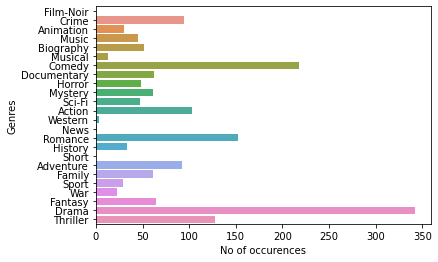

In [30]:
sns.barplot(y = list(genre_count.keys()), x=list(genre_count.values()))
plt.xlabel('No of occurences')
plt.ylabel('Genres')

**We Notice that drama's occur most frequently**

In [31]:
#Sort How many times each country appears
dict(sorted(country_count.items(), key=lambda item: item[1]))

{'Philippines': 0,
 'Ethiopia': 0,
 'Singapore': 0,
 'Bahamas': 0,
 'Malaysia': 0,
 'Iceland': 0,
 'Uruguay': 0,
 'Nigeria': 0,
 'Bolivia': 0,
 'Qatar': 0,
 'Chad': 0,
 'Belarus': 0,
 'Paraguay': 0,
 'Bosnia and Herzegovina': 0,
 'Malta': 0,
 'Monaco': 0,
 'Peru': 0,
 'Mongolia': 0,
 'Croatia': 0,
 'Ukraine': 0,
 'Namibia': 0,
 'Egypt': 0,
 'Albania': 0,
 'Dominican Republic': 0,
 'Taiwan': 0,
 'Mauritania': 0,
 'Greenland': 0,
 'Trinidad and Tobago': 0,
 'Algeria': 0,
 'Cayman Islands': 0,
 'Lithuania': 0,
 'Colombia': 0,
 'Tunisia': 0,
 'Tanzania': 0,
 'Cambodia': 0,
 'Ghana': 0,
 'Morocco': 0,
 'Ecuador': 0,
 'Latvia': 0,
 'Uganda': 0,
 'Slovenia': 0,
 'Jordan': 1,
 'Slovakia': 1,
 'Georgia': 1,
 'Saudi Arabia': 1,
 'Russia': 1,
 'Argentina': 1,
 'Kenya': 1,
 'Indonesia': 1,
 'Cameroon': 1,
 'Poland': 1,
 'Afghanistan': 1,
 'Lebanon': 1,
 'Serbia': 1,
 'Bulgaria': 1,
 'Chile': 2,
 'Portugal': 2,
 'Luxembourg': 2,
 'Norway': 2,
 'Isle Of Man': 2,
 'Soviet Union': 2,
 'Greece': 2,
 'F

***Note: We observe that the US is appears the most frequently***

In [32]:
#Sort How many times each language appears
dict(sorted(language_count.items(), key=lambda item: item[1]))

{'Bhojpuri': 0,
 'Hmong': 0,
 'Quechua': 0,
 'Macedonian': 0,
 'Acholi': 0,
 'Aramaic': 0,
 'North American Indian': 0,
 'Hawaiian': 0,
 'Esperanto': 0,
 'Yoruba': 0,
 'Awadhi': 0,
 'Swiss German': 0,
 'Pushto': 0,
 'Manipuri': 0,
 'Greenlandic': 0,
 'Songhay': 0,
 'Algonquin': 0,
 'Sign Languages': 0,
 'Romany': 0,
 'Tamil': 0,
 'Mongolian': 0,
 'Min Nan': 0,
 'Navajo': 0,
 'Scots': 0,
 'Burmese': 0,
 'Ibo': 0,
 'Kinyarwanda': 0,
 'Telugu': 0,
 'Dari': 0,
 'Bulgarian': 0,
 'None': 0,
 'Balinese': 0,
 'Corsican': 0,
 'Norwegian': 0,
 'Polynesian': 0,
 'Bambara': 0,
 'Albanian': 0,
 'Welsh': 0,
 'Flemish': 0,
 'Wolof': 0,
 'Masai': 0,
 'Shona': 0,
 'Kirundi': 0,
 'Bengali': 0,
 'Filipino': 0,
 'Somali': 0,
 'Inuktitut': 0,
 'Rajasthani': 0,
 'Syriac': 0,
 'Tamashek': 0,
 'Hakka': 0,
 'Tupi': 0,
 'Catalan': 0,
 'Armenian': 0,
 'Tagalog': 0,
 'Lithuanian': 0,
 'Polish': 1,
 'Icelandic': 1,
 'Shanghainese': 1,
 'Mohawk': 1,
 'Aboriginal': 1,
 'Slovak': 1,
 'Maya': 1,
 'Serbian': 1,
 'Sansk

**We obsevere that english has the highest occurence**

##### How Ratings Are Distributed Across the Data

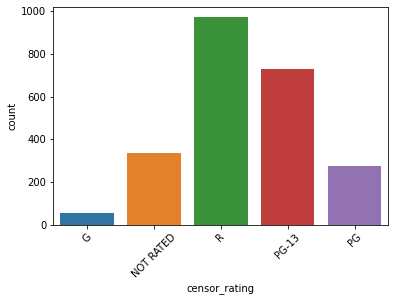

In [33]:
sns.countplot(train.censor_rating)
plt.xticks(rotation=45);

**We notice that R rated movies occur most frequently, we should investigate the relationship with these values and revenue category**

<AxesSubplot:xlabel='censor_rating', ylabel='count'>

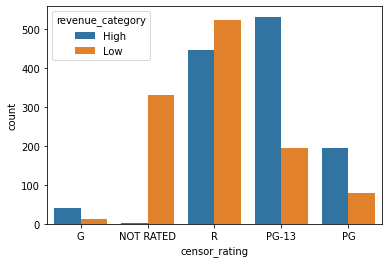

In [34]:
sns.countplot(x="censor_rating", hue="revenue_category", data=train)

**Note: We observe that movies that are not rated are often in the low revenue category**

#### The Relationship Between Movie Being In English and Revenue Category

We observed that more often than not movies not released in English where in the low revenue category. However some movies released in English where still low.

<AxesSubplot:xlabel='English', ylabel='count'>

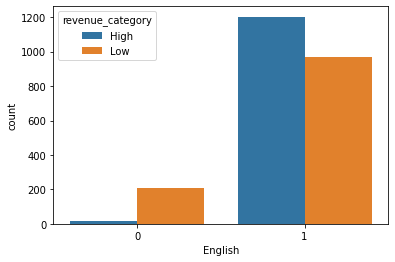

In [35]:
sns.countplot(x="English", hue="revenue_category", data=train)

#### The Relationship Between Movie Being released in USA and Revenue Category

We observed that more often than not movies not released in USA where in the low revenue category. However some but not most movies released in USA were also low.

<AxesSubplot:xlabel='USA', ylabel='count'>

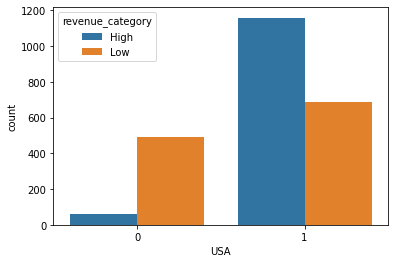

In [36]:
sns.countplot(x="USA", hue="revenue_category", data=train)

#### Writer Count

Here we analyse writer count. In the data set Movies in the high revenue category often have slightly more writers. Most movies have less than 5 writers.

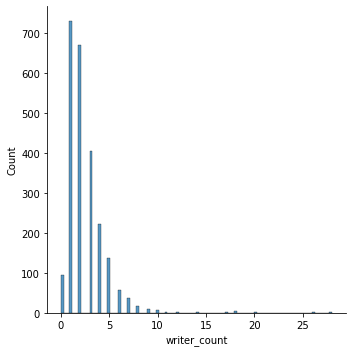

In [37]:
sns.displot(train.writer_count)

In [38]:
revenue_cat = train.groupby('revenue_category')['writer_count'].mean()

<AxesSubplot:xlabel='revenue_category'>

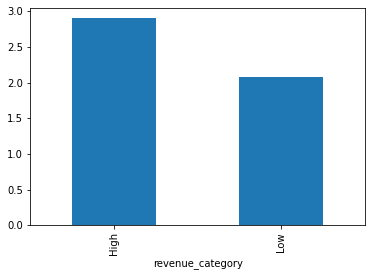

In [39]:
revenue_cat.plot(kind="bar")

#### Analysing The Distribution of Revenue Categories
**The distribution of revenue categories is fairly balanced in the dataset**

<AxesSubplot:xlabel='revenue_category', ylabel='count'>

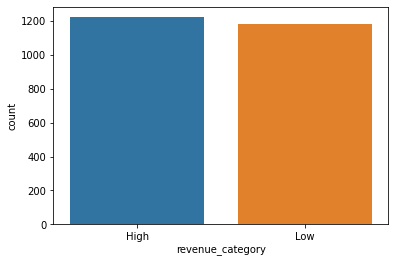

In [40]:
sns.countplot(x="revenue_category", data=train)

## Preprocessing

Previously, columns such as Language, Genre and Country where converted into individual boolean columns, this can be considered a feature engineering/preprocessing step. However we need to do a few more, namely:

1. Convert target column `Revenue Category` to booleans, High revenue will be considered 1, and Low will be considered Zero.
2. We will label encode the censor_rating columns.
3. Drop the original Language, country and genre columns.
4. Deal with missing values.


In [41]:
#convert target column to Numeric
train.revenue_category = np.where(train.revenue_category == "High", 1, 0)



In [42]:
#Label Encode Censor Rating

train.censor_rating.unique()

array(['G', 'NOT RATED', 'R', 'PG-13', 'PG', nan], dtype=object)

In [43]:
train.censor_rating.isna().sum()

38

In [44]:
train.censor_rating.unique()

array(['G', 'NOT RATED', 'R', 'PG-13', 'PG', nan], dtype=object)

In [45]:
#label encode censor_rating
ratings_map= {'G':1, 'NOT RATED': 0, 'PG':2, 'PG-13':3, 'R':4}
train.censor_rating = train.censor_rating.map(ratings_map)
test.censor_rating = test.censor_rating.map(ratings_map)

In [46]:
train.censor_rating.isna().sum()

38

In [47]:
train.drop(['language', 'country', 'genres'], axis=1, inplace=True)
test.drop(['language', 'country', 'genres'], axis=1, inplace=True)

In [48]:
train.title_adaption = np.where(train.title_adaption == True, 1, 0)
test.title_adaption = np.where(test.title_adaption == True, 1, 0)

## Feature Engineering

The dataset has two date columns which likely carry a lots of predictive information that can be lost if they are not mined properly. To extract as much information from the dates I follow these steps:

1. Extract day, month, year and put them in seperate columns.
2. Infer if the m

In [49]:
def mine_dates(data, release_date):
    data[release_date + "_dayofyear"] = data[release_date].dt.dayofyear
    data[release_date + "_month"] = data[release_date].dt.month
    data[release_date + "_year"] = data[release_date].dt.year
    data[release_date + '_is_month_end'] = data[release_date].dt.is_month_end.astype(int)
    data[release_date + '_is_month_start'] = data[release_date].dt.is_month_start.astype(int)
    data = data.drop([release_date], axis=1)
    return data

In [50]:
train = mine_dates(train, "release_date")
test = mine_dates(test, "release_date")
train = mine_dates(train, "dvd_release_date")
test = mine_dates(test, "dvd_release_date")

### Train Model 

### Dealing with missing values

Some missing values in certain columns were dealt with earlier, however for the bulk of missing values, we would impute them with the KNN imputer for our base line model, a more systematic approach can be taken in further iterations.



In [51]:
train_clean = train.copy()
test_clean = test.copy()

#Using the KNN method for the first two columns
imputer = KNNImputer(n_neighbors=4)
columns = train_clean.columns.values[1:]
train_clean[columns] = imputer.fit_transform(train_clean[columns])

#Using the KNN method for the first two columns
imputer = KNNImputer(n_neighbors=4)
columns = test_clean.columns.values[1:]
test_clean[columns] = imputer.fit_transform(test_clean[columns])

In [52]:
numerical_columns  = ['writer_count', 'title_adaption', 'runtime', 'users_votes', 'comments',
                      'likes', 'overall_views', 'dislikes','ratings_imdb','ratings_tomatoes',
                      'ratings_metacritic', 'special_award','awards_win','awards_nomination']

#Scaling ensures that all the columns are on on the same scale/unit
scaler = StandardScaler()
train_clean[numerical_columns] = scaler.fit_transform(train_clean[numerical_columns])

#Scaling ensures that all the columns are on on the same scale/unit
scaler = StandardScaler()
test_clean[numerical_columns] = scaler.fit_transform(test_clean[numerical_columns])

In [53]:
def fit_poly(data):
    poly = PolynomialFeatures(degree=2, interaction_only=True, include_bias=False)
    poly_fit = poly.fit_transform(data[numerical_columns])

    poly_frame = pd.DataFrame(poly_fit, columns=[f"poly1_{i}" for i in range(poly_fit.shape[1])])

    #reset columns indexes for smooth join
    data = data.reset_index().drop(columns="index")

    #join
    data =  pd.concat([data, poly_frame], axis = 1)
    
    return data

In [54]:
train_clean = fit_poly(train_clean)
test_clean = fit_poly(test_clean)

In [55]:
# Extract Features and Target Columns
features = train_clean.columns.values[train_clean.columns.values != "revenue_category"]
X = train_clean[features]
y = train_clean["revenue_category"]

### Feature Selection 

For the first run we will use all but one feature, the title feature. We would then use results of the initial model to inform the rest of the process.

In [56]:
X = X.iloc[: , 1:]
test_set = test_clean.iloc[:, 1:]
titles = test_clean.iloc[:, :1]


In [57]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)

### Model Training

We use a pipeline object to allow for easy addition of other components later in process

In [58]:
# define pipeline
steps = [('model', LGBMClassifier())]
pipeline = Pipeline(steps=steps)

# Create the parameter grid 
gbm_param_grid = {'model__reg_alpha': np.arange(0.05, 30, 0.25) , 'model__reg_lambda': np.arange(0.05, 40, 0.25), 
                  'model__learning_rate': np.arange(.05, 1, .05), 'model__max_depth': np.arange(3,200, 2),
                  'model__n_estimators': np.arange(20, 200, 25), 'model__subsample': np.arange(0.01, 1, 0.01),
                  'model__min_split_gain': np.arange(0.01, 1, 0.01),
                 'model__random_state': np.arange(1, 20, 1)} 

# evaluate pipeline
cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)

# Perform RandomizedSearchCV
randomized_roc_auc = RandomizedSearchCV(estimator=pipeline, param_distributions=gbm_param_grid, n_iter=2, scoring='roc_auc', cv=cv, verbose=1)

# Fit the estimator
randomized_roc_auc.fit(X_train, y_train)

# Compute metrics
print(randomized_roc_auc.best_score_)
print(randomized_roc_auc.best_estimator_)

Fitting 30 folds for each of 2 candidates, totalling 60 fits
0.9444737380821328
Pipeline(steps=[('model',
                 LGBMClassifier(learning_rate=0.2, max_depth=99,
                                min_split_gain=0.06999999999999999,
                                n_estimators=45, random_state=13,
                                reg_alpha=10.05, reg_lambda=15.55,
                                subsample=0.49))])


In [59]:
y_preds = randomized_roc_auc.predict(X_test)

f1_score(y_preds, y_test)

0.8981132075471697

In [60]:
final_model = LGBMClassifier(learning_rate=0.05, max_depth=23,
                                min_split_gain=0.81, n_estimators=120,
                                random_state=13, reg_alpha=12.8,
                                reg_lambda=37.3, subsample=0.67)

In [61]:
final_model.fit(X, y)
Submission = final_model.predict(test_set)

In [62]:
titles["revenue_category"] = np.where(Submission == 1, "High", "Low")

In [63]:
titles.to_csv('Submission.csv')

#### Model Valuation

The accuracy score can be sometimes misleading, to offset this we can use the F1 score as our key evaluation metric. As it considers the nature of classification errors.

The dataset seems to be slightly overfit on the training set:
1. introduce regularization
2. reduce variance by decreasing the model's complexity. 
3. Introduce feature selection